In [1]:
# regular imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.python.framework import ops

In [2]:
# xgboost import is a bit more annoying on windows 
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
from xgboost.sklearn import XGBClassifier

In [2]:
# load in training feature vectors
X_train_w2v = np.hstack((np.load('data/numpy/trainQuotes_w2v.npy'), np.load('data/numpy/trainResponses_w2v.npy')))
mask = ~np.any(np.isnan(X_train_w2v), axis=1)
X_train_w2v = X_train_w2v[mask]
X_train_lex = np.hstack((np.load('data/numpy/trainQuotes_lex.npy'), np.load('data/numpy/trainResponses_lex.npy')))
X_train_lex = X_train_lex[mask]
X_train = np.hstack((X_train_w2v, X_train_lex))
Y_train = np.load('data/numpy/Y_train.npy')
Y_train = Y_train[mask]
del(X_train_w2v)
del(X_train_lex)

# load in testing feature vectors
X_test_w2v = np.hstack((np.load('data/numpy/testQuotes_w2v.npy'), np.load('data/numpy/testResponses_w2v.npy')))
mask = ~np.any(np.isnan(X_test_w2v), axis=1)
X_test_w2v = X_test_w2v[mask]
X_test_lex = np.hstack((np.load('data/numpy/testQuotes_lex.npy'), np.load('data/numpy/testResponses_lex.npy')))
X_test_lex = X_test_lex[mask]
X_test = np.hstack((X_test_w2v, X_test_lex))
Y_test = np.load('data/numpy/Y_test.npy')
Y_test = Y_test[mask]
del(X_test_w2v)
del(X_test_lex)

# get dimensions 
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Number of training examples = 255172
Number of test examples = 63979
X_train shape: (255172, 622)
Y_train shape: (255172,)
X_test shape: (63979, 622)
Y_test shape: (63979,)


In [3]:
# let's standardize our data to zero mean and unit variance
scaler = StandardScaler().fit(X_train)
scaler.transform(X_train)
scaler.transform(X_test)

array([[ 0.07621724,  0.39352818,  0.02832511, ..., -0.36054126,
         1.11712671,  0.76182969],
       [ 0.07621724,  0.39352818,  0.02832511, ...,  2.2139665 ,
         1.11712671,  0.76182969],
       [-0.21173121, -0.8557401 ,  0.50537816, ...,  2.2139665 ,
        -0.5186266 ,  1.55857384],
       ..., 
       [ 1.75541732,  0.33144348, -0.35827232, ..., -0.36054126,
        -0.5186266 , -0.03491446],
       [-1.06008903, -0.91331281, -0.09098241, ..., -0.36054126,
         1.11712671, -0.03491446],
       [-1.06008903, -0.91331281, -0.09098241, ..., -0.36054126,
        -0.5186266 , -0.03491446]])

In [6]:
# start with basic logistic regression
lr = LogisticRegression()

start = time.time()
lr.fit(X_train, Y_train)
lr_train_acc = lr.score(X_train, Y_train) 
lr_test_acc = lr.score(X_test, Y_test)
Y_test_pred = lr.predict(X_test)
lr_class_counts = Counter(Y_test_pred)
lr_prec = precision_score(Y_test, Y_test_pred)
lr_rec = recall_score(Y_test, Y_test_pred)
print("Logistic Regression took {:.2f} minutes".format((time.time() - start) / 60))
print("Training Accuracy of Logistic Regression: %.2f%%" % (lr_train_acc * 100.0))
print("Testing Accuracy of Logistic Regression: %.2f%%" % (lr_test_acc * 100.0))
print("Logistic Regression testing class counts: ", lr_class_counts)
print("Testing Precision of Logistic Regression: %.2f%%" % (lr_prec * 100.0))
print("Testing Recall of Logistic Regression:  %.2f%%" % (lr_rec * 100.0))

Logistic Regression took 3.35 minutes
Training Accuracy of Logistic Regression: 54.73%
Testing Accuracy of Logistic Regression: 54.64%
Logistic Regression testing class counts:  Counter({1: 32487, 0: 31492})
Testing Precision of Logistic Regression: 54.74%
Testing Recall of Logistic Regression:  55.39%


In [ ]:
# hyperparameter optimization for logistic regression 

# construct the set of hyperparameters to tune
params = {"C": [0.001,0.01,0.1,1,10,100,1000]}

# tune the hyperparameters via a cross-validated grid search
print("[INFO] tuning hyperparameters via grid search")
grid_lr = GridSearchCV(lr, params)
start = time.time()
grid_lr.fit(X_train, Y_train)
 
# evaluate the best grid searched model on the testing data
grid_lr_train_acc = grid_lr.score(X_train, Y_train) 
grid_lr_test_acc = grid_lr.score(X_test, Y_test)
grid_Y_test_pred = grid_lr.predict(X_test)
grid_lr_class_counts = Counter(grid_Y_test_pred)
grid_lr_prec = precision_score(Y_test, grid_Y_test_pred)
grid_lr_rec = recall_score(Y_test, grid_Y_test_pred)
print("Logistic Regression Grid Search took {:.2f} minutes".format((time.time() - start) / 60))

In [10]:
print("Grid search best parameters: {}".format(grid_lr.best_params_))
print("Training Accuracy of Logistic Regression: %.2f%%" % (grid_lr_train_acc * 100.0))
print("Testing Accuracy of Logistic Regression: %.2f%%" % (grid_lr_test_acc * 100.0))
print("Logistic Regression testing class counts: ", grid_lr_class_counts)
print("Testing Precision of Logistic Regression: %.2f%%" % (grid_lr_prec * 100.0))
print("Testing Recall of Logistic Regression:  %.2f%%" % (grid_lr_rec * 100.0))

Grid search best parameters: {'C': 1000}
Training Accuracy of Logistic Regression: 59.68%
Testing Accuracy of Logistic Regression: 59.32%
Logistic Regression testing class counts:  Counter({0: 32189, 1: 31790})
Testing Precision of Logistic Regression: 59.56%
Testing Recall of Logistic Regression:  58.97%


In [ ]:
# let's try Naive Bayes
nb = GaussianNB()

start = time.time()
nb.fit(X_train, Y_train)
nb_train_acc = nb.score(X_train, Y_train) 
nb_test_acc = nb.score(X_test, Y_test)
Y_test_pred = nb.predict(X_test)
nb_class_counts = Counter(Y_test_pred)
nb_prec = precision_score(Y_test, Y_test_pred)
nb_rec = recall_score(Y_test, Y_test_pred)
print("Naive Bayes took {:.2f} minutes".format((time.time() - start) / 60))
print("Training Accuracy of Naive Bayes: %.2f%%" % (nb_train_acc * 100.0))
print("Testing Accuracy of Naive Bayes: %.2f%%" % (nb_test_acc * 100.0))
print("Naive Bayes testing class counts: ", nb_class_counts)
print("Testing Precision of Naive Bayes: %.2f%%" % (nb_prec * 100.0))
print("Testing Recall of Naive Bayes:  %.2f%%" % (nb_rec * 100.0))

Naive Bayes took 0.22 minutes
Training Accuracy of Naive Bayes: 54.18%
Testing Accuracy of Naive Bayes: 54.21%
Naive Bayes testing class counts:  Counter({1: 42510, 0: 21469})
Testing Precision of Naive Bayes: 53.31%
Testing Recall of Naive Bayes:  70.58%


In [5]:
# now let's try XGBoost
xgb = XGBClassifier(silent=False, n_jobs=-1, eval_metric='error')

start = time.time()
xgb.fit(X_train, Y_train)
Y_train_pred = xgb.predict(X_train)
Y_train_pred = [round(value) for value in Y_train_pred]
Y_test_pred = xgb.predict(X_test)
Y_test_pred = [round(value) for value in Y_test_pred]
xgb_class_counts = Counter(Y_test_pred)
xgb_train_acc = accuracy_score(Y_train, Y_train_pred)
xgb_test_acc = accuracy_score(Y_test, Y_test_pred)
xgb_prec = precision_score(Y_test, Y_test_pred)
xgb_rec = recall_score(Y_test, Y_test_pred)
print("XGBoost took {:.2f} minutes".format((time.time() - start) / 60))
print("Training Accuracy of XGBoost: %.2f%%" % (xgb_train_acc * 100.0))
print("Testing Accuracy of XGBoost: %.2f%%" % (xgb_test_acc * 100.0))
print("XGBoost testing class counts: ", xgb_class_counts)
print("Testing Precision of XGBoost: %.2f%%" % (xgb_prec * 100.0))
print("Testing Recall of XGBoost:  %.2f%%" % (xgb_rec * 100.0))

XGBoost took 20.40 minutes
Training Accuracy of XGBoost: 60.71%
Testing Accuracy of XGBoost: 59.46%
XGBoost testing class counts:  Counter({0: 33044, 1: 30935})
Testing Precision of XGBoost: 59.98%
Testing Recall of XGBoost:  57.79%


In [ ]:
# let's tune xgboost hyperparameters 
xgb = XGBClassifier(n_jobs=-1, eval_metric='error')
# construct the set of hyperparameters to tune
params = {'max_depth':range(3,10,2),
          'min_child_weight':range(1,6,2),
          'gamma':[i/10.0 for i in range(0,5)], 
          'subsample':[i/10.0 for i in range(6,10)],
          'colsample_bytree':[i/10.0 for i in range(6,10)], 
          'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

# tune the hyperparameters via a cross-validated randomized search
print("[INFO] tuning hyperparameters via randomized search")
rand_xgb = RandomizedSearchCV(xgb, params, n_iter=20)
start = time.time()
rand_xgb.fit(X_train, Y_train)

In [34]:
# evaluate the best grid searched model on the testing data
rand_xgb_train_acc = rand_xgb.score(X_train, Y_train) 
rand_xgb_test_acc = rand_xgb.score(X_test, Y_test)
rand_Y_test_pred = rand_xgb.predict(X_test)
rand_xgb_class_counts = Counter(rand_Y_test_pred)
rand_xgb_prec = precision_score(Y_test, rand_Y_test_pred)
rand_xgb_rec = recall_score(Y_test, rand_Y_test_pred)
print("XGBoost Randomized Search took {:.2f} minutes".format((time.time() - start) / 60))
print("Randomized search best parameters: {}".format(rand_xgb.best_params_))
print("Training Accuracy of XGBoost: %.2f%%" % (rand_xgb_train_acc * 100.0))
print("Testing Accuracy of XGBoost: %.2f%%" % (rand_xgb_test_acc * 100.0))
print("XGBoost testing class counts: ", rand_xgb_class_counts)
print("Testing Precision of XGBoost: %.2f%%" % (rand_xgb_prec * 100.0))
print("Testing Recall of XGBoost:  %.2f%%" % (rand_xgb_rec * 100.0))

XGBoost Randomized Search took 1480.19 minutes
Randomized search best parameters: {'subsample': 0.9, 'reg_alpha': 0.01, 'min_child_weight': 3, 'max_depth': 7, 'gamma': 0.1, 'colsample_bytree': 0.8}
Training Accuracy of XGBoost: 71.73%
Testing Accuracy of XGBoost: 61.24%
XGBoost testing class counts:  Counter({0: 33260, 1: 30719})
Testing Precision of XGBoost: 61.89%
Testing Recall of XGBoost:  59.22%


In [4]:
# let's start building our NN architecture
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(C, name="C")
    one_hot_matrix = tf.one_hot(labels, C, 1)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
        
    return one_hot

Y_train = one_hot_matrix(Y_train, 2)
Y_test = one_hot_matrix(Y_test, 2)
print(Y_train.shape)
print(Y_test.shape)

(255172, 2)
(63979, 2)


In [5]:
def create_placeholders(num_features, num_classes):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    num_features -- scalar, number of features
    num_classes -- scalar, number of classes 
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=[None, num_features])
    Y = tf.placeholder(tf.float32, shape=[None, num_classes])
    
    return X, Y

In [6]:
def initialize_parameters(num_features, num_classes, num_layers, units_per_layer):
    """
    Initializes parameters to build a neural network with tensorflow. 
    
    Arguments:
    num_features -- scalar, number of features
    num_classes -- scalar, number of classes 
    num_layers -- scalar, number of layers in our neural network
    units_per_layer -- array of length num_layers, each item is a scalar corresponding to size of number of units in the layer
    
    Returns:
    parameters -- a dictionary of tensors containing our parameters
    """
    weights = [None] * num_layers
    biases = [None] * num_layers
    for i in range(num_layers):
        if i == 0:
            weights[i] = tf.get_variable("W" + str(i), [num_features, units_per_layer[i]], 
                                         initializer=tf.contrib.layers.xavier_initializer())
            biases[i] = tf.get_variable("b" + str(i), [1, units_per_layer[i]], initializer=tf.zeros_initializer())
        elif i == (num_layers - 1):
            weights[i] = tf.get_variable("W" + str(i), [units_per_layer[i-1], num_classes], 
                                         initializer=tf.contrib.layers.xavier_initializer())
            biases[i] = tf.get_variable("b" + str(i), [1, num_classes], initializer=tf.zeros_initializer())
        else:
            weights[i] = tf.get_variable("W" + str(i), [units_per_layer[i-1], units_per_layer[i]], 
                                         initializer=tf.contrib.layers.xavier_initializer())
            biases[i] = tf.get_variable("b" + str(i), [1, units_per_layer[i]], initializer=tf.zeros_initializer())
        
    
    parameters = {"weights": weights,
                  "biases": biases}
    
    return parameters

In [7]:
def forward_propagation(X, parameters, activation, dropout=False, keep_prob = 0.8):
    """
    Implements the forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder, of shape (Number of examples, number of features)
    parameters -- python dictionary containing your parameters 
    activation -- activation function to use, string
    dropout -- bool, whether or not to use dropout
    keep_prob -- used for dropout

    Returns:
    Z -- the output of the last unit
    """
    
    weights = parameters['weights']
    biases  = parameters['biases']
    Z = 0.0; A = 0.0
    
    for i in range(len(weights)):
        if i == 0:
            Z = tf.add(tf.matmul(X, weights[i]), biases[i])
        else:
            if dropout:
                Z = tf.add(tf.matmul(drop_A, weights[i]), biases[i])
            else:
                Z = tf.add(tf.matmul(A, weights[i]), biases[i])
  
        if activation == "relu":
            A = tf.nn.relu(Z)
            if dropout:
                drop_A = tf.nn.dropout(A, keep_prob)
        elif activation == "softplus":
            A = tf.nn.softplus(Z)
            if dropout:
                drop_A = tf.nn.dropout(A, keep_prob)
    return Z

In [14]:
def compute_cost(Z, Y, weights, l2_penalty=False, beta = 0.01):
    """
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last unit)
    Y -- "true" labels vector placeholder, same shape as Z
    weights -- needed for l2 regularization
    l2_penalty -- bool, whether or not to add a l2 penalty to cost function
    beta -- scale of how much regularization impacts cost
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    if l2_penalty:
        regularizers = 0.0
        for i in range(len(weights)):
            regularizers += tf.nn.l2_loss(weights[i])
        cost = tf.reduce_mean(cost + (beta * regularizers))
    
    return cost

In [15]:
def random_mini_batches(X, Y, mini_batch_size):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data
    Y -- true "label" vector
    mini_batch_size - size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [30]:
def model(X_train, Y_train, X_test, Y_test, num_layers, 
          units_per_layer, activation='relu', dropout = False,
          clipping = False, l2_penalty=False, beta=0.001, 
          keep_prob=0.8, learning_rate = 0.001, max_num_epochs = 500, 
          threshold = 1e-4, minibatch_size = 32, print_cost = True):
    """
    Implements a tensorflow neural network
    
    Arguments:
    X_train -- training set features
    Y_train -- training set class values
    X_test -- test set features
    Y_test -- test set class values
    activation -- string for which activation function to use
    dropout - bool for whether or not to use dropout
    clipping -- bool for whether or not to use gradient clipping
    keep_prob -- probability for dropout
    learning_rate -- learning rate of the optimization
    max_num_epochs -- number of epochs of the optimization loop
    threshold -- convergence threshold to stop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, num_features) = X_train.shape                 # (m : number of examples in the train set, n_features: input size)
    num_classes = Y_train.shape[1]                      # n_classes : output size
    costs = []                                        # To keep track of the cost
    
    # Create placeholders
    X, Y = create_placeholders(num_features, num_classes)

    # Initialize parameters
    parameters = initialize_parameters(num_features, num_classes, num_layers, units_per_layer)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters, activation, dropout, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y, parameters['weights'], l2_penalty, beta)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    if clipping:
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        grads, variables = zip(*optimizer.compute_gradients(cost))
        grads = [None if grad is None else tf.clip_by_norm(grad, 5.0) for grad in grads]
        optimizer = optimizer.apply_gradients(zip(grads, variables))
    else:
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(max_num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            
            costs.append(epoch_cost)
           
            if epoch != 0:
                if abs(costs[-2] - costs[-1]) < threshold:
                    print ("Final Cost after epoch %i: %f" % (epoch, epoch_cost))
                    break
            
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z,1), tf.argmax(Y,1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        keep_prob = 1.0
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Neural Network with no Regularization
Cost after epoch 0: 0.695220
Cost after epoch 10: 0.664980
Cost after epoch 20: 0.647051
Cost after epoch 30: 0.620507
Cost after epoch 40: 0.585953
Cost after epoch 50: 0.551421
Cost after epoch 60: 0.517775
Cost after epoch 70: 0.485884
Cost after epoch 80: 0.455522
Cost after epoch 90: 0.427159
Cost after epoch 100: 0.399840
Cost after epoch 110: 0.376701
Cost after epoch 120: 0.354028
Cost after epoch 130: 0.330637
Cost after epoch 140: 0.315959
Cost after epoch 150: 0.297409
Cost after epoch 160: 0.286332
Cost after epoch 170: 0.266993
Cost after epoch 180: 0.254695
Cost after epoch 190: 0.250215
Cost after epoch 200: 0.235357
Cost after epoch 210: 0.225478
Cost after epoch 220: 0.217532
Cost after epoch 230: 0.210281
Cost after epoch 240: 0.197888
Cost after epoch 250: 0.194924
Cost after epoch 260: 0.186651
Cost after epoch 270: 0.180498
Final Cost after epoch 272: 0.175829


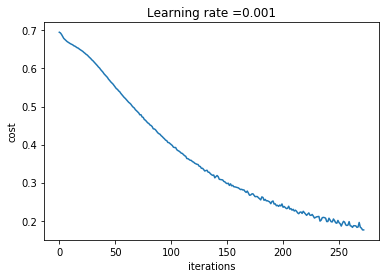

Parameters have been trained!
Train Accuracy: 0.931509
Test Accuracy: 0.551228
Neural Network took 100.34 minutes


Neural Network with Dropout (20%) Regularization
Cost after epoch 0: 0.695830
Cost after epoch 10: 0.675304
Cost after epoch 20: 0.664644
Cost after epoch 30: 0.657748
Cost after epoch 40: 0.650169
Cost after epoch 50: 0.643098
Cost after epoch 60: 0.636262
Cost after epoch 70: 0.629028
Cost after epoch 80: 0.621720
Cost after epoch 90: 0.613496
Cost after epoch 100: 0.607039
Cost after epoch 110: 0.599781
Cost after epoch 120: 0.593575
Final Cost after epoch 125: 0.589518


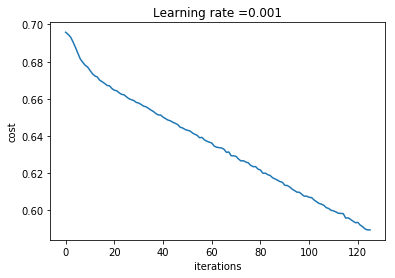

Parameters have been trained!
Train Accuracy: 0.679875
Test Accuracy: 0.576033
Neural Network took 55.37 minutes


Neural Network with L2 Regularization
Cost after epoch 0: 0.704555
Cost after epoch 10: 0.693868
Cost after epoch 20: 0.692105
Cost after epoch 30: 0.689771
Cost after epoch 40: 0.686352
Cost after epoch 50: 0.681590
Cost after epoch 60: 0.676283
Cost after epoch 70: 0.671096
Cost after epoch 80: 0.667177
Final Cost after epoch 84: 0.665768


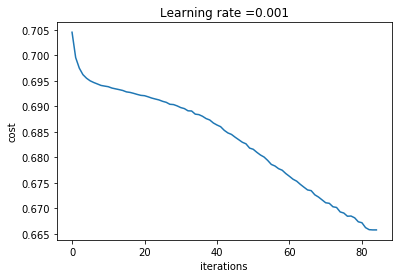

Parameters have been trained!
Train Accuracy: 0.598612
Test Accuracy: 0.520499
Neural Network took 28.24 minutes


Neural Network with Dropout (20%) and L2 Regularization
Cost after epoch 0: 0.705999
Cost after epoch 10: 0.694639
Final Cost after epoch 19: 0.693924


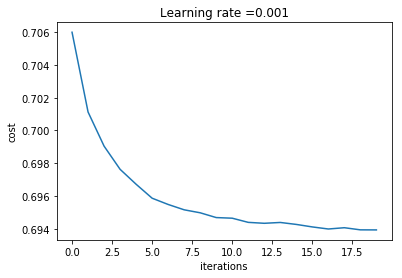

Parameters have been trained!
Train Accuracy: 0.53085
Test Accuracy: 0.523219
Neural Network took 8.69 minutes


In [31]:
num_layers = 4
units_per_layer = [400, 200, 100, 50]

print("Neural Network with no Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) and L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=500, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))

Neural Network with no Regularization
Cost after epoch 0: 0.695270
Cost after epoch 10: 0.667694
Cost after epoch 20: 0.653999
Cost after epoch 30: 0.641740
Cost after epoch 40: 0.628371
Cost after epoch 50: 0.616152
Cost after epoch 60: 0.602935
Cost after epoch 70: 0.591294
Cost after epoch 80: 0.579460
Cost after epoch 90: 0.568868
Cost after epoch 100: 0.556535
Cost after epoch 110: 0.547146
Cost after epoch 120: 0.535938
Cost after epoch 130: 0.527152
Cost after epoch 140: 0.517185
Cost after epoch 150: 0.509563
Cost after epoch 160: 0.497781
Cost after epoch 170: 0.489865
Cost after epoch 180: 0.480739
Cost after epoch 190: 0.471282
Cost after epoch 200: 0.463183
Cost after epoch 210: 0.454222
Cost after epoch 220: 0.446756
Cost after epoch 230: 0.438161
Cost after epoch 240: 0.430751
Cost after epoch 250: 0.422722
Cost after epoch 260: 0.415110
Cost after epoch 270: 0.407644
Cost after epoch 280: 0.400810
Cost after epoch 290: 0.393256


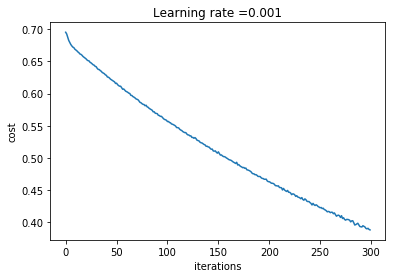

Parameters have been trained!
Train Accuracy: 0.833967
Test Accuracy: 0.561153
Neural Network took 53.76 minutes


Neural Network with Dropout (20%) Regularization
Cost after epoch 0: 0.695804
Cost after epoch 10: 0.675163
Cost after epoch 20: 0.666414
Cost after epoch 30: 0.660723
Cost after epoch 40: 0.655547
Cost after epoch 50: 0.651835
Cost after epoch 60: 0.647155
Cost after epoch 70: 0.642648
Cost after epoch 80: 0.639196
Cost after epoch 90: 0.634677
Cost after epoch 100: 0.630675
Cost after epoch 110: 0.626187
Final Cost after epoch 114: 0.625033


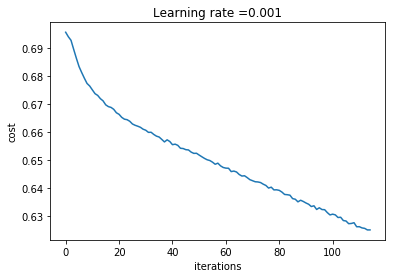

Parameters have been trained!
Train Accuracy: 0.650436
Test Accuracy: 0.589475
Neural Network took 25.82 minutes


Neural Network with L2 Regularization
Cost after epoch 0: 0.700383
Cost after epoch 10: 0.693191
Cost after epoch 20: 0.691586
Final Cost after epoch 23: 0.691072


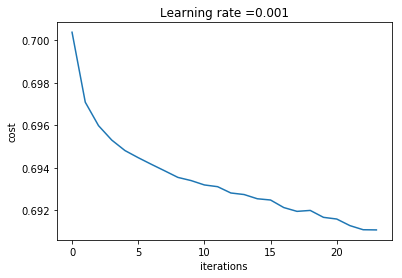

Parameters have been trained!
Train Accuracy: 0.546447
Test Accuracy: 0.52461
Neural Network took 4.44 minutes


Neural Network with Dropout (20%) and L2 Regularization
Cost after epoch 0: 0.701349
Cost after epoch 10: 0.694140
Cost after epoch 20: 0.693224
Cost after epoch 30: 0.692732
Final Cost after epoch 30: 0.692732


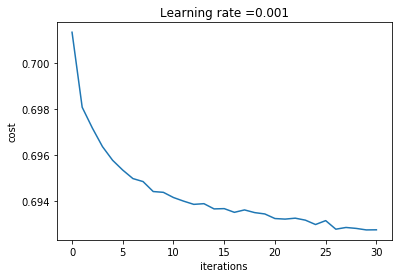

Parameters have been trained!
Train Accuracy: 0.53788
Test Accuracy: 0.524469
Neural Network took 7.14 minutes


In [32]:
num_layers = 3
units_per_layer = [200, 200, 200]

print("Neural Network with no Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) and L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=500, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))

Neural Network with no Regularization
Cost after epoch 0: 0.695374
Cost after epoch 10: 0.665200
Cost after epoch 20: 0.648979
Cost after epoch 30: 0.630684
Cost after epoch 40: 0.609063
Cost after epoch 50: 0.586841
Cost after epoch 60: 0.563929
Cost after epoch 70: 0.543641
Cost after epoch 80: 0.523464
Cost after epoch 90: 0.502664
Cost after epoch 100: 0.484604
Cost after epoch 110: 0.465322
Cost after epoch 120: 0.447541
Cost after epoch 130: 0.428589
Cost after epoch 140: 0.412770
Cost after epoch 150: 0.394081
Cost after epoch 160: 0.380801
Cost after epoch 170: 0.363564
Cost after epoch 180: 0.346871
Cost after epoch 190: 0.332625
Cost after epoch 200: 0.317045
Cost after epoch 210: 0.306210
Cost after epoch 220: 0.292759
Cost after epoch 230: 0.277953
Cost after epoch 240: 0.268545
Cost after epoch 250: 0.255710
Cost after epoch 260: 0.243372
Cost after epoch 270: 0.233115
Cost after epoch 280: 0.220562
Cost after epoch 290: 0.212514


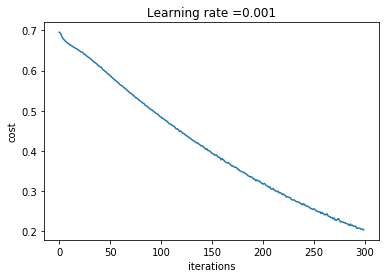

Parameters have been trained!
Train Accuracy: 0.923248
Test Accuracy: 0.553088
Neural Network took 96.21 minutes


Neural Network with Dropout (20%) Regularization
Cost after epoch 0: 0.695994
Cost after epoch 10: 0.674275
Cost after epoch 20: 0.664678
Cost after epoch 30: 0.656785
Cost after epoch 40: 0.649841
Cost after epoch 50: 0.642772
Cost after epoch 60: 0.636559
Cost after epoch 70: 0.629481
Cost after epoch 80: 0.622909
Cost after epoch 90: 0.616734
Cost after epoch 100: 0.609915
Cost after epoch 110: 0.603719
Cost after epoch 120: 0.597117
Cost after epoch 130: 0.590112
Cost after epoch 140: 0.582873
Cost after epoch 150: 0.577074
Cost after epoch 160: 0.571232
Cost after epoch 170: 0.565903
Cost after epoch 180: 0.559765
Final Cost after epoch 185: 0.557360


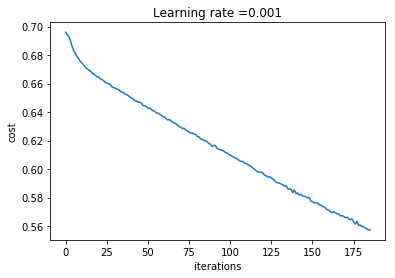

Parameters have been trained!
Train Accuracy: 0.706567
Test Accuracy: 0.577017
Neural Network took 76.94 minutes


Neural Network with L2 Regularization
Cost after epoch 0: 0.702170
Cost after epoch 10: 0.693434
Cost after epoch 20: 0.691943
Cost after epoch 30: 0.689764
Cost after epoch 40: 0.687308
Cost after epoch 50: 0.684244
Cost after epoch 60: 0.680862
Cost after epoch 70: 0.677936
Cost after epoch 80: 0.675272
Final Cost after epoch 88: 0.673272


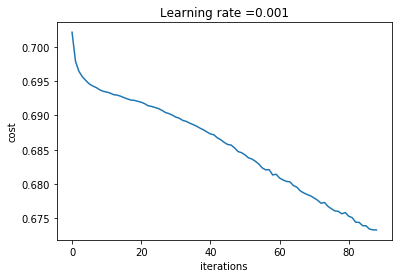

Parameters have been trained!
Train Accuracy: 0.593745
Test Accuracy: 0.524125
Neural Network took 28.77 minutes


Neural Network with Dropout (20%) and L2 Regularization
Cost after epoch 0: 0.703325
Cost after epoch 10: 0.694366
Cost after epoch 20: 0.693518
Cost after epoch 30: 0.692798
Final Cost after epoch 35: 0.692614


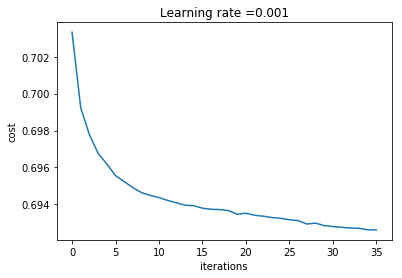

Parameters have been trained!
Train Accuracy: 0.540761
Test Accuracy: 0.527345
Neural Network took 14.91 minutes


In [33]:
num_layers = 3
units_per_layer = [400, 200, 100]

print("Neural Network with no Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) and L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=500, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))

Neural Network with no Regularization
Cost after epoch 0: 0.694798
Cost after epoch 10: 0.671712
Cost after epoch 20: 0.664013
Cost after epoch 30: 0.659074
Cost after epoch 40: 0.655674
Cost after epoch 50: 0.653183
Cost after epoch 60: 0.650887
Cost after epoch 70: 0.649018
Final Cost after epoch 77: 0.648019


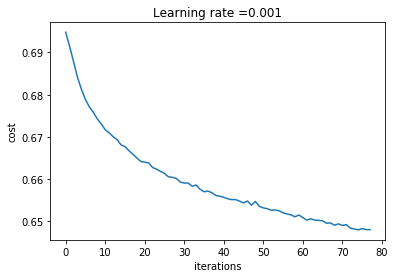

Parameters have been trained!
Train Accuracy: 0.627718
Test Accuracy: 0.596477
Neural Network took 11.46 minutes


Neural Network with Dropout (20%) Regularization
Cost after epoch 0: 0.696501
Cost after epoch 10: 0.676268
Cost after epoch 20: 0.669356
Final Cost after epoch 25: 0.666893


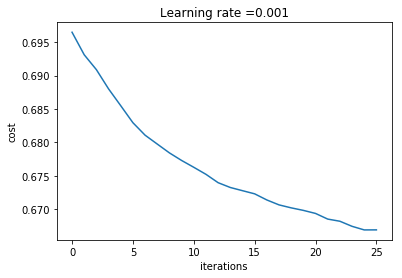

Parameters have been trained!
Train Accuracy: 0.599188
Test Accuracy: 0.592429
Neural Network took 4.32 minutes


Neural Network with L2 Regularization
Cost after epoch 0: 0.697137
Cost after epoch 10: 0.693236
Final Cost after epoch 15: 0.692753


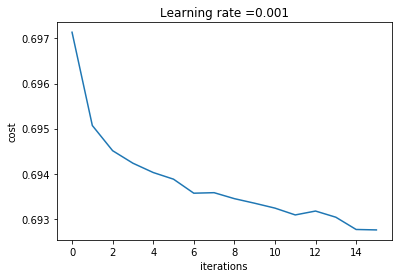

Parameters have been trained!
Train Accuracy: 0.534498
Test Accuracy: 0.523
Neural Network took 2.44 minutes


Neural Network with Dropout (20%) and L2 Regularization
Cost after epoch 0: 0.697765
Cost after epoch 10: 0.693668
Final Cost after epoch 16: 0.693392


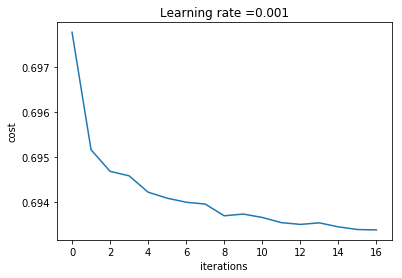

Parameters have been trained!
Train Accuracy: 0.530477
Test Accuracy: 0.520671
Neural Network took 3.20 minutes


In [34]:
num_layers = 2
units_per_layer = [200, 200]

print("Neural Network with no Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) and L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=500, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))

Neural Network with no Regularization
Cost after epoch 0: 0.695540
Cost after epoch 10: 0.664539
Cost after epoch 20: 0.640926
Cost after epoch 30: 0.595600
Cost after epoch 40: 0.526920
Cost after epoch 50: 0.461267
Cost after epoch 60: 0.406195
Cost after epoch 70: 0.357231
Cost after epoch 80: 0.313457
Cost after epoch 90: 0.290508
Cost after epoch 100: 0.252696
Cost after epoch 110: 0.233245
Cost after epoch 120: 0.209019
Cost after epoch 130: 0.198205
Cost after epoch 140: 0.182169
Cost after epoch 150: 0.170235
Cost after epoch 160: 0.162882
Cost after epoch 170: 0.136791
Cost after epoch 180: 0.150764
Cost after epoch 190: 0.132611
Cost after epoch 200: 0.135655
Cost after epoch 210: 0.132247
Cost after epoch 220: 0.110375
Cost after epoch 230: 0.110456
Cost after epoch 240: 0.109700
Cost after epoch 250: 0.117762
Cost after epoch 260: 0.080586
Final Cost after epoch 265: 0.077470


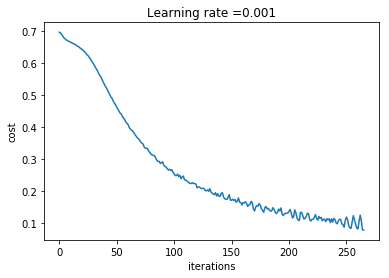

Parameters have been trained!
Train Accuracy: 0.966427
Test Accuracy: 0.544991
Neural Network took 349.49 minutes


Neural Network with Dropout (20%) Regularization
Cost after epoch 0: 0.695850
Cost after epoch 10: 0.672331
Cost after epoch 20: 0.660693
Cost after epoch 30: 0.648916
Cost after epoch 40: 0.634716
Cost after epoch 50: 0.617798
Cost after epoch 60: 0.600711
Cost after epoch 70: 0.583213
Cost after epoch 80: 0.567813
Cost after epoch 90: 0.550086
Cost after epoch 100: 0.535643
Cost after epoch 110: 0.521381
Cost after epoch 120: 0.508323
Cost after epoch 130: 0.498240
Final Cost after epoch 132: 0.496390


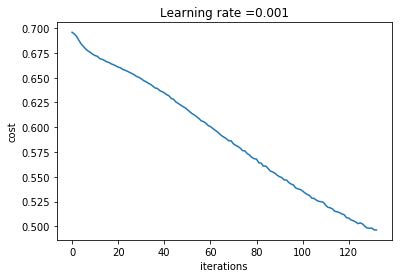

Parameters have been trained!
Train Accuracy: 0.747727
Test Accuracy: 0.565514
Neural Network took 198.92 minutes


Neural Network with L2 Regularization
Cost after epoch 0: 0.714037
Cost after epoch 10: 0.693816
Cost after epoch 20: 0.692096
Cost after epoch 30: 0.690077
Cost after epoch 40: 0.687235
Cost after epoch 50: 0.683396
Cost after epoch 60: 0.679442
Cost after epoch 70: 0.676023
Cost after epoch 80: 0.672620
Cost after epoch 90: 0.670342
Cost after epoch 100: 0.668579
Final Cost after epoch 106: 0.667450


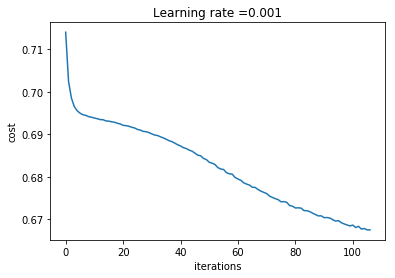

Parameters have been trained!
Train Accuracy: 0.593627
Test Accuracy: 0.521765
Neural Network took 138.23 minutes


Neural Network with Dropout (20%) and L2 Regularization
Cost after epoch 0: 0.716157
Cost after epoch 10: 0.694441
Final Cost after epoch 16: 0.694013


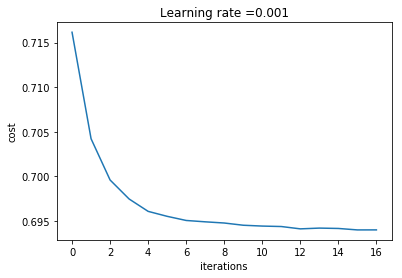

Parameters have been trained!
Train Accuracy: 0.531602
Test Accuracy: 0.523625
Neural Network took 26.81 minutes


In [35]:
num_layers = 4
units_per_layer = [1000, 500, 250, 125]

print("Neural Network with no Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=False,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (20%) and L2 Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=True, beta=0.00005, keep_prob=0.8, learning_rate=0.001, max_num_epochs=500, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))

Neural Network with Dropout (30%) Regularization
Cost after epoch 0: 0.696232
Cost after epoch 10: 0.677882
Cost after epoch 20: 0.668439
Cost after epoch 30: 0.663141
Cost after epoch 40: 0.659086
Cost after epoch 50: 0.654609
Cost after epoch 60: 0.650897
Cost after epoch 70: 0.646745
Cost after epoch 80: 0.642017
Cost after epoch 90: 0.637546
Cost after epoch 100: 0.634357
Cost after epoch 110: 0.630592
Cost after epoch 120: 0.626273
Cost after epoch 130: 0.622216
Cost after epoch 140: 0.617512
Cost after epoch 150: 0.612715
Cost after epoch 160: 0.610640
Cost after epoch 170: 0.605928
Cost after epoch 180: 0.602108
Cost after epoch 190: 0.598791
Cost after epoch 200: 0.594007
Cost after epoch 210: 0.591046
Cost after epoch 220: 0.587600
Cost after epoch 230: 0.585179
Cost after epoch 240: 0.582118
Cost after epoch 250: 0.578161
Cost after epoch 260: 0.576076
Cost after epoch 270: 0.573221
Cost after epoch 280: 0.570657
Cost after epoch 290: 0.567765


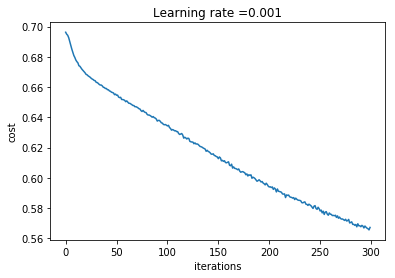

Parameters have been trained!
Train Accuracy: 0.697823
Test Accuracy: 0.578705
Neural Network took 153.15 minutes


Neural Network with Dropout (40%) Regularization
Cost after epoch 0: 0.696502
Cost after epoch 10: 0.681074
Cost after epoch 20: 0.672532
Cost after epoch 30: 0.667512
Cost after epoch 40: 0.664596
Cost after epoch 50: 0.661023
Cost after epoch 60: 0.658478
Cost after epoch 70: 0.655497
Cost after epoch 80: 0.653154
Cost after epoch 90: 0.650459
Cost after epoch 100: 0.647919
Cost after epoch 110: 0.645067
Cost after epoch 120: 0.642737
Cost after epoch 130: 0.639321
Cost after epoch 140: 0.636600
Cost after epoch 150: 0.633702
Cost after epoch 160: 0.631394
Cost after epoch 170: 0.628881
Cost after epoch 180: 0.626904
Cost after epoch 190: 0.623639
Final Cost after epoch 199: 0.621359


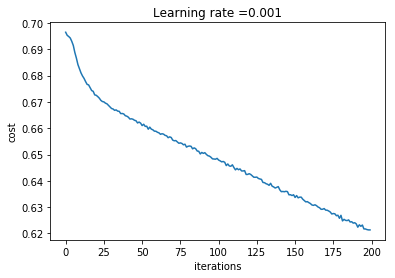

Parameters have been trained!
Train Accuracy: 0.650655
Test Accuracy: 0.584067
Neural Network took 82.60 minutes


Neural Network with Dropout (50%) Regularization
Cost after epoch 0: 0.697521
Cost after epoch 10: 0.685435
Cost after epoch 20: 0.676574
Cost after epoch 30: 0.671655
Cost after epoch 40: 0.669076
Cost after epoch 50: 0.666873
Cost after epoch 60: 0.664252
Cost after epoch 70: 0.662901
Cost after epoch 80: 0.661053
Cost after epoch 90: 0.659179
Final Cost after epoch 93: 0.658248


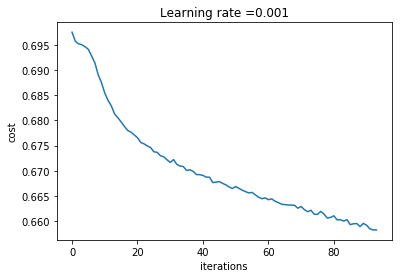

Parameters have been trained!
Train Accuracy: 0.610651
Test Accuracy: 0.589678
Neural Network took 39.00 minutes




In [37]:
num_layers = 4
units_per_layer = [400, 200, 100, 50]

print("Neural Network with Dropout (30%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.7, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (40%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.6, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")

print("Neural Network with Dropout (50%) Regularization")
start = time.time()
parameters = model(X_train, Y_train, X_test, Y_test, num_layers, units_per_layer, activation='relu', dropout=True,
          clipping=True, l2_penalty=False, beta=0.001, keep_prob=0.5, learning_rate=0.001, max_num_epochs=300, 
          threshold=1e-5, minibatch_size=1024, print_cost=True)
print("Neural Network took {:.2f} minutes".format((time.time() - start) / 60))
print("\n")